# Prédiction de matchs de Tennis 

> Test technique DataGenius

> Date : Février 2018

> Auteur : Mathilde Boltenhagen

L'objectif de ce notebook est d'étudier une base de données de matchs de tennis afin de trouver un modèle permettant de prédire les gagnants. Pour cela, nous allons séparer les étapes d'analyse suivant le plan ci-dessous. 

[I. Découverte du jeu de données](#titre1)

Chargement des tables, première sélection des colonnes selon choix arbitraire, valeur sémantique.

[II. Nettoyage des données ](#titre2)

Normaliser les données numériques, binariser les données catégorielles, gérer les données de type DATE. 

[III. Sélection de variables ](#titre3)

Utilisation de RandomForest pour garder les variables les plus intéressantes

[IV. Création de modèles ](#titre3)

Apprentissage sur les données train selon le meilleur modèle. Test avec une librairie sklearn qui divise le datatrain en deux,test et train, fait du cross-validation et donne l'accuracy. 


**Note : j'ai renommé le fichier test.csv en test_without_pred.csv afin de ne pas l'écraser avec le nom demandé pour l'évaluation **


# I. Découverte du jeu de données <a id="titre1"></a>

Le premier but est de comprendre la structure des données et de reconstruire la base de données de telle sorte à ne garder que les éléments qui nous semblent intéressants. Nous allons donc charger les fichiers un à un, comprendre les éléments essentiels et essayer de construire une unique table. 

#### Players
Nous commençons par étudier la table players et constatons de nombreuses colonnes dont nous n'avons pas les descriptions et qui sont très souvent à valeur inconnue. On retient alors les colonnes "ID_P", "DATE_P", "COUNTRY_P", "NAME_P" et "RANK_P". La date de naissance pourrait être un facteur de réussite. Le nom du joueur n'est pas forcément intéressant puisque nous avons l'identifiant.

In [1]:
import pandas as pd
import numpy as np

# on récupère les données
players = pd.read_csv("players.csv",usecols=["ID_P","DATE_P","COUNTRY_P","RANK_P" ])
print(players.head(2))
print(players.shape)

   ID_P               DATE_P COUNTRY_P  RANK_P
0     1  1976-09-10 00:00:00       BRA     NaN
1     2  1980-01-27 00:00:00       RUS     NaN
(55562, 4)


Nous avons 55562 joueurs de Tennis dans cette base de données. On constate que la colonne RANK_P a l'air souvent null et comptons alors le nombre de valeurs manquantes. 

In [2]:
print("Nombre de valeurs nulles de RANK_P :",np.sum(players["RANK_P"].isnull()))
print("Nombre de joueurs ayant un rang : ",players.shape[0]-np.sum(players["RANK_P"].isnull()))

Nombre de valeurs nulles de RANK_P : 54662
Nombre de joueurs ayant un rang :  900


On comprend que 900 joueurs sont classés et risque d'avoir des chances de gagner les matchs face à des joueurs non-classés. C'est donc une donnée utile malgré les valeurs manquantes!

#### Player_rates

La table player_rates contient 5 colonnes. La première est inutile car nous n'avons pas besoin d'un ID de cette table. Toutes les autres semblent intéressantes. On comprend que ID_P_R est l'identifiant d'un joueur, DATE_R la date du classement, POINT_R le nombre de points et POS_R le classement du joueur à la DATE_R.

In [3]:
player_rates = pd.read_csv("player_rates.csv")
print(player_rates.head(2))

   Unnamed: 0               DATE_R  ID_P_R  POINT_R  POS_R
0           0  2012-01-02 00:00:00    5992    13630      1
1           1  2012-01-02 00:00:00     677     9595      2


In [4]:
# suppression de la première colonne inutile
player_rates.drop(player_rates.columns[0],axis="columns", inplace=True)
print(player_rates.shape)
print(len(player_rates["ID_P_R"].unique()))

(172154, 4)
1487


On note que nous avons beaucoup de données de rating mais pour peu de joueurs. Seulement 1487 joueurs sur 55562 ont des données dans cette table. 


#### Stats

La table stats contient tout le déroulement des matchs. Nous décidons de garder toutes les colonnes pour le moment sauf l'ID de la table qui ne nous est pas utile. 

In [5]:
stats = pd.read_csv("stats.csv")
stats.drop(stats.columns[0],axis="columns", inplace=True)
stats.describe()

,ID1,ID2,ID_T,ID_R,FS_1,FSOF_1,ACES_1,DF_1,UE_1,W1S_1,...,NA_2,NAOF_2,TPW_2,FAST_2,A1S_2,A2S_2,RPW_1,RPWOF_1,RPW_2,RPWOF_2
count,75611.000000,75611.000000,75611.000000,75611.000000,75609.000000,75609.000000,74898.000000,75389.000000,5369.000000,75611.000000,...,2725.000000,2724.000000,75611.000000,1714.000000,1681.000000,1681.000000,75126.000000,75126.000000,75126.000000,75126.000000
mean,13959.548981,15796.505575,11302.224716,4.769094,42.391408,68.063736,4.813813,2.567125,18.518346,31.524130,...,15.118165,25.168869,62.336803,203.645858,181.467579,148.671624,30.767404,70.676876,22.348801,67.988766
std,11331.907039,11960.425345,1384.629138,2.984649,15.694843,23.895156,4.261745,2.165058,17.756322,10.905907,...,10.177354,16.827049,25.230421,10.306285,10.293447,10.267051,9.295796,23.513114,10.846689,23.847717
min,7.000000,7.000000,8879.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,157.000000,138.000000,121.000000,0.000000,0.000000,0.000000,0.000000
25%,5136.000000,6487.000000,10033.000000,3.000000,31.000000,51.000000,2.000000,1.000000,3.000000,24.000000,...,8.000000,14.000000,44.000000,197.000000,175.000000,142.000000,24.000000,54.000000,14.000000,51.000000
50%,11332.000000,12662.000000,11347.000000,4.000000,40.000000,63.000000,4.000000,2.000000,14.000000,30.000000,...,13.000000,22.000000,58.000000,203.000000,182.000000,148.000000,29.000000,66.000000,21.000000,63.000000
75%,21329.000000,24240.000000,12763.000000,5.000000,51.000000,82.000000,7.000000,4.000000,29.000000,37.000000,...,20.000000,32.000000,78.000000,210.000000,188.000000,155.000000,36.000000,84.000000,29.000000,82.000000
max,52028.000000,52129.000000,13422.000000,17.000000,181.000000,243.000000,53.000000,24.000000,128.000000,141.000000,...,90.000000,163.000000,290.000000,242.000000,211.000000,191.000000,105.000000,249.000000,85.000000,243.000000


#### Tour 

La table tour contient de nombreuses données sur le tournoi. Seul le pays me semble un critère intéressant dans la réussite d'un joueur. 

In [6]:
tour = pd.read_csv("tour.csv", usecols=["ID_T","DATE_T","COUNTRY_T"])
tour.head(2)

,ID_T,DATE_T,COUNTRY_T
0,1,1997-01-01 00:00:00,AUS
1,2,1997-01-01 00:00:00,QAT


#### Test & Train 

Les tables test et train ont la même structure hormis la colonne resultat qui est absente pour le jeu de test. 

In [7]:
test = pd.read_csv("test_without_pred.csv")
test.head(2)

,ID1_G,ID2_G,ID_T_G,ID_R_G,DATE_G
0,19942,32203,13204,5,2016-05-25 00:00:00
1,14609,20648,12992,5,2016-06-01 00:00:00


In [8]:
train = pd.read_csv("train.csv")
train.drop(train.columns[0],axis="columns", inplace=True)
train.head(2)

,ID1_G,ID2_G,ID_T_G,ID_R_G,RESULT_G,DATE_G
0,17613,18854,8887,4,7-6(8) 3-6 10-7,2012-01-31 00:00:00
1,25192,25191,8888,4,6-3 6-2,2012-01-31 00:00:00


#### Merge

L'idée est de rassembler les données afin de les traiter par la suite. 

In [9]:
def merge_data(df) : 
    # on ajoute le joueur 1
    df = pd.merge(df, players, how='left', left_on=['ID1_G'], right_on=['ID_P'])
    df.columns = df.columns.map(lambda x: x + "_1" if x in players.columns else x)

    # le joueur 2 
    df = pd.merge(df, players, how='left', left_on=['ID2_G'], right_on=['ID_P'])
    df.columns = df.columns.map(lambda x: x + "_2" if x in players.columns else x)

    # les données du classement 
    df =  pd.merge(df, player_rates, how='left', left_on=['DATE_G','ID1_G'], right_on=['DATE_R','ID_P_R'])
    df.columns = df.columns.map(lambda x: x + "_1" if x in player_rates.columns else x)
    df =  pd.merge(df, player_rates, how='left', left_on=['DATE_G','ID2_G'], right_on=['DATE_R','ID_P_R'])
    df.columns = df.columns.map(lambda x: x + "_2" if x in player_rates.columns else x)

    # le tournoi
    df =  pd.merge(df, tour, how='left', left_on=['ID_T_G'], right_on=['ID_T'])

    # stats
    df = pd.merge(df, stats, how='left', left_on=['ID_T_G','ID1_G','ID2_G',"ID_R_G"], right_on=['ID_T',"ID1","ID2","ID_R"])
    return df 

merged_train = merge_data(train)
merged_test = merge_data(test)

merged_train.columns

Index(['ID1_G', 'ID2_G', 'ID_T_G', 'ID_R_G', 'RESULT_G', 'DATE_G', 'ID_P_1',
       'DATE_P_1', 'COUNTRY_P_1', 'RANK_P_1', 'ID_P_2', 'DATE_P_2',
       'COUNTRY_P_2', 'RANK_P_2', 'DATE_R_1', 'ID_P_R_1', 'POINT_R_1',
       'POS_R_1', 'DATE_R_2', 'ID_P_R_2', 'POINT_R_2', 'POS_R_2', 'ID_T_x',
       'DATE_T', 'COUNTRY_T', 'ID1', 'ID2', 'ID_T_y', 'ID_R', 'FS_1', 'FSOF_1',
       'ACES_1', 'DF_1', 'UE_1', 'W1S_1', 'W1SOF_1', 'W2S_1', 'W2SOF_1',
       'WIS_1', 'BP_1', 'BPOF_1', 'NA_1', 'NAOF_1', 'TPW_1', 'FAST_1', 'A1S_1',
       'A2S_1', 'FS_2', 'FSOF_2', 'ACES_2', 'DF_2', 'UE_2', 'W1S_2', 'W1SOF_2',
       'W2S_2', 'W2SOF_2', 'WIS_2', 'BP_2', 'BPOF_2', 'NA_2', 'NAOF_2',
       'TPW_2', 'FAST_2', 'A1S_2', 'A2S_2', 'RPW_1', 'RPWOF_1', 'RPW_2',
       'RPWOF_2', 'MT'],
      dtype='object')

# II. Nettoyage des données  <a id="titre2"></a>

On retire d'abord les données que nous avons en double avec les merges ou qui sont inutiles à l'apprentissage. 

In [10]:
# supprime les doublons et colonne ID non utiles 
def delete_double(df) :
    df.drop(["ID1","ID2","ID_P_1","ID_P_2",'DATE_R_1',"DATE_T",'ID_P_R_1','DATE_R_2','ID_P_R_2','ID_T_x',"ID_T_y","ID_R"],axis="columns",inplace=True)
    
delete_double(merged_train)
delete_double(merged_test)

Nous allons étudié le type des différentes données ainsi que le nombre de valeurs nulles et leur valeur sémantique. Par exemple la variable MT donne le temps au format DATE du mi-temps. Il serait plus intéressante de l'avoir au format secondes. 
De plus, il va falloir normaliser les valeurs numériques, étudier les variables catégorielles...

In [11]:
from datetime import datetime,date
from datetime import timedelta

def to_seconds(t):
     return int(timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()) 

players["DATE_P"] = players["DATE_P"].apply(lambda x : date.today().year- datetime.strptime(x,'%Y-%m-%d 00:00:00').year if isinstance(x,str) else None)
players["DATE_P"].fillna(np.mean(players["DATE_P"]),inplace=True)

def refactor_dates(df):
    # age joueur 1
    df["DATE_P_1"] = df["DATE_P_1"].apply(lambda x : date.today().year- datetime.strptime(x,'%Y-%m-%d 00:00:00').year if isinstance(x,str) else None  )
    df["DATE_P_1"].fillna(np.mean(players["DATE_P"]),inplace=True)
    
    # age joueur 2
    df["DATE_P_2"] = df["DATE_P_2"].apply(lambda x : date.today().year- datetime.strptime(x,'%Y-%m-%d 00:00:00').year if isinstance(x,str) else None  )
    df["DATE_P_2"].fillna(np.mean(players["DATE_P"]),inplace=True)

    # temps mi-temps
    df["MT"] = df["MT"].apply(lambda x : to_seconds(datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) if isinstance(x,str) else np.NaN )
    df["MT"].fillna(np.nanmean(df["MT"]),inplace=True)

refactor_dates(merged_test)
refactor_dates(merged_train)

On remarque que la date du tournoi peut aussi être intéressante, des joueurs peuvent être en meilleure condition à certaines dates. Nous devons la transformer. Pour cela nous séparons l'année et le mois. Les dates de test sont uniquement en 2016, il ne faut pas oublier de mettre des valeurs nulles aux autres colonnes des années précédantes. En effet, peut-être que des joueurs étaient bon à certaines années. 

In [12]:
# date, on garde l'heure et le mois et on fait des données catégorielles
merged_train["YEAR"] = merged_train["DATE_G"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d 00:00:00').year if isinstance(x,str) else np.NaN  )
merged_test["YEAR"] = merged_train["DATE_G"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d 00:00:00').year if isinstance(x,str) else np.NaN  )
merged_train["MONTH"] = merged_train["DATE_G"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d 00:00:00').month if isinstance(x,str) else np.NaN  )
merged_test["MONTH"] = merged_test["DATE_G"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d 00:00:00').month if isinstance(x,str) else np.NaN  )

# categorise YEAR pour train set 
merged_train["YEAR"] = merged_train["YEAR"].astype('category')
year_labels = merged_train["YEAR"].cat.categories.tolist() 
newdf = pd.DataFrame([merged_train["YEAR"].cat.codes]).transpose()

from sklearn.preprocessing import OneHotEncoder

# on fait un one to many pour binariser la variable catégorielle
newdf=pd.DataFrame(OneHotEncoder().fit_transform(newdf).toarray())
# on remet les noms des années
newdf.columns = [str(x) for x in year_labels]
# on rajoute au dataset 
merged_train = pd.concat([merged_train,newdf],axis=1, join='inner')

# pour le data test on ajoute simplement 4 colonnes à 0 et 2016 à 1 
for i in range (2012,2016) : 
    merged_test[str(i)]=0
merged_test["2016"]=1

# De même pour les mois 
def categorise_mois(df):
    newdf = pd.DataFrame([df["MONTH"]]).transpose()
    newdf = pd.DataFrame(OneHotEncoder().fit_transform(newdf).toarray())
    newdf.columns = ["month_" + str(x) for x in newdf.columns ]
    df = pd.concat([df,newdf],axis=1, join='inner')


categorise_mois(merged_train)
categorise_mois(merged_test)

In [13]:
def remove_useless_cols(df):
    df.drop(["DATE_G","YEAR","MONTH"],axis="columns",inplace=True)
    
remove_useless_cols(merged_train)
remove_useless_cols(merged_test)

Le pays est aussi une données catégorielle. Il y a 175 pays disponibles et nous avons 2 données de types pays : joueur1 et joueur2. Nous allons tout de même créer ces variables binaires mais nous utiliserons une méthode de sélection de variables par la suite. 

Tout d'abord notons qu'un joueur qui joue dans son pays n'a pas de temps de transport qui pourrait le fatiguer. On va donc noter si le joueur joue dans son pays ou non.

In [14]:
def pays_faveur_gagnant(df):
    df["COUNTRY_FAVOR_1"]=  df.apply(lambda row: 1 if row["COUNTRY_P_1"]==row["COUNTRY_T"] else 0 , axis=1) 
    df["COUNTRY_FAVOR_2"]=  df.apply(lambda row: 1 if row["COUNTRY_P_2"]==row["COUNTRY_T"] else 0 , axis=1) 

pays_faveur_gagnant(merged_train)
pays_faveur_gagnant(merged_test)


Pour la catégorisation des pays, le datatest et le datatrain doivent avoir les mêmes colones donc on récupère bien tous les pays des joueurs possibles pour les deux colonnes "COUNTRY_P_i" de chacune des tables.

In [15]:
# on récupère tous les pays possible
players["COUNTRY_P"].fillna("null",inplace=True)
players["COUNTRY_P"] = players["COUNTRY_P"].astype('category')
total_pays = players["COUNTRY_P"].cat.categories.tolist() 

In [16]:
def categorise_pays(df):
    for i in ["COUNTRY_P_1","COUNTRY_P_2"] : 
        df[i].fillna("null",inplace=True)
        df[i] = df[i].astype('category')
        P_i_pays = df[i].cat.categories.tolist() 
        miss_P_i = [ x for x in total_pays if x not in P_i_pays ]
        newdf = pd.DataFrame([df[i].cat.codes]).transpose()
        
        newdf=pd.DataFrame(OneHotEncoder().fit_transform(newdf).toarray())
        newdf.columns = [ "Country_"+i+"_"+x for x in P_i_pays] 
        df = pd.concat([df,newdf],axis=1, join='inner')
        
        # les pays qui ne sont pas dans la colonne
        for pays in miss_P_i : 
            df["Country_"+i+"_"+pays]=0
    return df
            
train = categorise_pays(merged_train)
test = categorise_pays(merged_test)

In [17]:
test.drop(["COUNTRY_T","COUNTRY_P_1","COUNTRY_P_2"], axis="columns",inplace=True)
train.drop(["COUNTRY_T","COUNTRY_P_1","COUNTRY_P_2"],axis="columns", inplace=True)

Pour toutes les colonnes statistiques null, on suppose que la valeur vaut 0 et n'a pas été remplie vu que c'est des données de types "combien de points a-t-il eu pour telle condition". 

In [18]:
def stats_null_values(df):
    for col in stats.columns :
        if col in df.columns : 
            df[col].fillna(0,inplace=True)

stats_null_values(test)
stats_null_values(train)

Les données de classement des joueurs utilisent la même idée. Si un joueur n'est pas classé alors on peut lui donner le classement le plus nul. 

In [19]:
def rank_point_pos(df):
    for i in [1,2]:
        i=str(i)
        # si pas de rang, on met un plus élevé que le max
        df["RANK_P_"+i].fillna(np.max(df["RANK_P_"+i]),inplace=True)
        
        # si pas de points => 0 
        df["POINT_R_"+i].fillna(0,inplace=True)
        
        # pos max aussi
        df["POS_R_"+i].fillna(np.max(df["POS_R_"+i]),inplace=True)
        
rank_point_pos(test)
rank_point_pos(train)

On vérifie qu'il n'y a plus de colonnes contenant des valeurs nulles dans nos deux jeux de données. On vérifie que nos deux jeux de données ont bien les même colonnes. 

In [20]:
for col in train.columns:
    if train[col].isnull().sum() :
        print (col)
        
for col in test.columns:
    if test[col].isnull().sum() :
        print (col)
        
for name in train.columns :
    if name not in test.columns:
        print(name)

RESULT_G


On retire les colonnes qui sont constantes dans le dataTrain car elles n'apporteront rien à l'apprentissage : 

In [21]:
train_less_result = train.drop(["RESULT_G"],axis="columns")
result = train["RESULT_G"]

# si la colonne a une seule et unique valeur dans sa colonne
train_less_result = train_less_result.loc[:,train_less_result.apply(pd.Series.nunique) != 1]
test = test.loc[:,train_less_result.columns]

print(train_less_result.shape)
print(test.shape)


(73366, 292)
(6097, 292)


Il faut maintenant normaliser les données :

In [22]:
from sklearn.preprocessing import MinMaxScaler

# on normalise les données test sur la même echelle que les données train
df_total= pd.concat([test, train_less_result], axis="rows")
    
# normalise les données entre 0 et 1
scaler = MinMaxScaler()
# on ne normalise pas les ids 
normalized_df = scaler.fit_transform(df_total[df_total.columns[4:]])
normalized_df = pd.DataFrame(normalized_df)
normalized_df.columns = df_total.columns[4:]
df = pd.concat([df_total[df_total.columns[:4]],normalized_df] ,axis=1, join='inner')

On sépare les données test et train à nouveau : 

In [23]:
test = df[:test.shape[0]]
train = df[test.shape[0]:]

print(train.shape)
print(test.shape)

(73366, 292)
(6097, 292)


Ensuite on se dit que lors de l'entrainement du modèle, si le joueur 1 a gagné contre le joueur 2 alors le joueur 2 a perdu contre le joueur1. Je décide alors de doubler mon jeu de données en rajoutant les lignes contraires.

In [24]:
# le joueur 1 gagne ici
train["RESULT"]=1
train.shape

/home/boltenhagen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(73366, 293)

In [25]:
# on inverse les données des joueurs 
columns_1 = [ x for x in train.columns if ( "1" in x and x not in ["2012","2013","2014","2015","2016",'W1S_2','W1SOF_2','A1S_2'] )]
columns_2 = [ x for x  in train.columns if "2" in x and x not in ["2012","2013","2014","2015","2016","W2S_1","W2SOF_1","A2S_1"]]
other_columns = [ x for x in train.columns if ("2" not in x and "1" not in x) or x in ["2012","2013","2014","2015","2016"]]

df_1 = train[columns_1]
df_1.columns = [ x.replace("_1","_2") for x in columns_1]
df_1.columns.values[0]= "ID2_G"
df_2 = train[columns_2]
df_2.columns =  [ x.replace("_2","_1") for x in columns_2]
df_2.columns.values[0]= "ID1_G"

new_rows = pd.concat([df_1,df_2,train[other_columns]],axis="columns",join="inner")
# le joueur 1 perd ici
new_rows["RESULT"]=0

# avec la suppression des valeurs constantes, certaines colonnes ont été supprimé. on adapte new_rows
for col in train.columns :
    if col not in new_rows.columns : 
        new_rows[col]=0

for col in new_rows.columns :
    if col not in train.columns :
        new_rows.drop([col],inplace=True,axis="columns")

# ordonner 
new_rows = new_rows[train.columns]

In [26]:
# on double ainsi le jeu de données
double_train = pd.concat([train,new_rows],axis="rows")
double_train.shape

(146732, 293)

# III. Sélection de variables  <a id="titre3"></a>
On a maintenant beaucoup de colonnes et nous allons essayer d'en retirer un certain nombre avec la méthode du **RandomForest** qui permet de mettre en valeur les anomalies mais aussi d'ordonner les features. 

In [27]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# on sépare la réponse
X = double_train.drop(["RESULT"],axis="columns")
Y = double_train["RESULT"]

# on entraine le modèle
clf = RandomForestClassifier()
clf.fit(X, Y)
importances=clf.feature_importances_

# on affiche l'importance des variables
sorted_idx = np.argsort(importances)[::-1]
features =np.arange(1, X.shape[1]+1)
padding = np.arange(X.size/len(X)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

On remarque qu'environ 1 sixième des variables est intéressant.

In [28]:
# on note les variables à garder 
keep_first_columns = sorted_idx[:int(len(sorted_idx)/6)]
keep_first_columns_names = [X.columns.values[i] for i in keep_first_columns ]
print(keep_first_columns_names)

['POS_R_1', 'POS_R_2', 'BP_2', 'DATE_P_1', 'BP_1', 'BPOF_1', 'ID_T_G', 'DATE_P_2', 'ACES_2', 'BPOF_2', 'TPW_2', 'TPW_1', 'RPW_1', '2016', 'W1S_1', 'FS_2', 'W1S_2', 'RPW_2', 'W1SOF_1', 'W1SOF_2', 'W2SOF_2', 'RPWOF_2', 'ACES_1', 'FSOF_1', 'POINT_R_2', 'POINT_R_1', 'RPWOF_1', 'MT', 'W2S_1', 'RANK_P_1', 'FS_1', 'FSOF_2', 'W2S_2', 'ID1_G', 'RANK_P_2', 'Country_COUNTRY_P_2_null', 'DF_1', 'W2SOF_1', 'ID2_G', 'Country_COUNTRY_P_1_null', 'DF_2', '2012', '2015', '2014', '2013', 'ID_R_G', 'WIS_2', 'WIS_1']


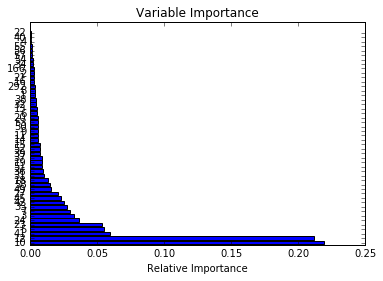

In [29]:
# on revisualise l'importance des variables
X_first = X[keep_first_columns_names]

features =np.arange(1, X.shape[1]+1)
padding = np.arange(X_first.size/len(X_first)) + 0.5
plt.barh(padding, importances[keep_first_columns], align='center')
plt.yticks(padding, features[keep_first_columns])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

On fait suivre le data test :

In [30]:
X_test_first = test[keep_first_columns_names]

# IV. Création de modèles <a id="titre4"></a>

On va lancer plusieurs modèles pour voir lequel est le plus pertinent. Nous utilisons pour cela "cross_val_score" qui permet de faire une cross validation, crée un data test/train dans le jeu de données et permet différents types de scores. Ici nous utiliserons l'accuracy. 


In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import AffinityPropagation

clfs = {
'NBS': GaussianNB(),
'CART' : DecisionTreeClassifier(), # pas de paramètre car CART par défaut
'ID3' : DecisionTreeClassifier(criterion='entropy'),
'STUMP' : DecisionTreeClassifier(max_depth=1),
'MLP': MLPClassifier(hidden_layer_sizes=(20,10)),
'KNN': KNeighborsClassifier(n_neighbors=10),
'BAG': BaggingClassifier(n_estimators=50),
'ADAB' : AdaBoostClassifier(n_estimators=50),
'RF': RandomForestClassifier(n_estimators=50)
}

def get_scores(dico, X,Y):
    for i in clfs:
        clf = clfs[i] 
        cv_acc = cross_val_score(clf, X, Y, cv=10)#pour le calcul de l’accuracy
        print("Accuracy for {0} is: {1:.3f} +/-{2:.3f}".format(i,np.mean(cv_acc), np.std(cv_acc)))
        print()
    
#get_scores(clfs,X_first,Y)
af = AffinityPropagation().fit(X_first)

MemoryError: 

On a déjà des modèles très intéressants. Les résultats semblent logiques car le KNN n'est pas pertinent avec des ID comme le MLP. De plus, suite à mes anciennes études, j'ai remarqué que le RandomForestClassifier était très souvent dans les premiers pertients. C'est donc celui ci que nous retenons. 

On teste un nombre d'estimateurs plus grands. 

In [32]:
clf =  RandomForestClassifier(n_estimators=200)
cv_acc = cross_val_score(clf, X_first, Y, cv=10)#pour le calcul de l’accuracy
print("Accuracy is: {1:.3f} +/-{2:.3f}".format(i,np.mean(cv_acc), np.std(cv_acc)))

Accuracy is: 0.922 +/-0.229


On remarque que le taux d'erreur ne change pas avec le nombre d'estimateurs. Le classifieur est plutôt bon alors on peut le lancer sur les données de test. 

In [33]:
clf  =  RandomForestClassifier(n_estimators=50)
clf.fit(X_first,Y)
predicted = clf.predict(X_test_first)

On peut enfin préparer les données de sorties.

In [42]:
keep_for_results = test[["ID1_G","ID2_G","ID_T_G","ID_R_G"]]
keep_for_results.reset_index(inplace=True)
keep_for_results.drop(["index"],axis="columns",inplace=True)
results = pd.concat([keep_for_results,pd.DataFrame([predicted]).transpose()],axis="columns",join="inner")
results.columns=["ID_1","ID_2","ID_T","ID_R","Winner"]
results["Winner"].replace(0,2,inplace=True)
results.head(2)

C:\Users\schei\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID_1,ID_2,ID_T,ID_R,Winner
0,19942,32203,13204,5,1
1,14609,20648,12992,5,1


In [43]:
results.to_csv("test.csv",sep=",")

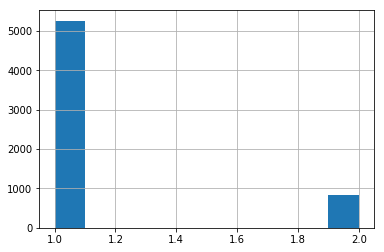

In [49]:
results["Winner"].hist()
plt.show()

Je suis un peu septique des résultats et l'étape suivante de mon étude serait de vérifier si la moyenne des classement  des joueurs 1 est plus faible (classement faible => meilleur joueur) que celle des les joueurs 2 dans le data test.

In [50]:
#on recharge les données
player_rates = pd.read_csv("player_rates.csv")
player_rates.drop(["Unnamed: 0","DATE_R","POINT_R"], axis="columns", inplace=True)
test = pd.read_csv("test_without_pred.csv")

In [51]:
# on fait la moyenne des rangs par joueurs 
player_rates = player_rates["POS_R"].groupby(player_rates["ID_P_R"]).mean()

In [52]:
import numpy as np

# refactor les nouvelles données
liste = np.array(player_rates.index)
values = player_rates.values
df1 = pd.concat([pd.DataFrame([liste]).transpose(),pd.DataFrame([values]).transpose()], axis="columns")
df1.columns = ["ID","POS_1"]

In [53]:
# on ajoute les rangs aux données de test
df = pd.merge(test,df1, left_on = "ID1_G", right_on="ID", how="left")
df.drop(["ID"],axis="columns",inplace=True)
df1.columns = ["ID","POS_2"]
df = pd.merge(df,df1, left_on = "ID2_G", right_on="ID", how="left")
df.drop(["ID"],axis="columns",inplace=True)

# on indique que s'il n'y a pas de rang alors il est très élevé (mauvais rang)
df.fillna(1000,inplace=True)


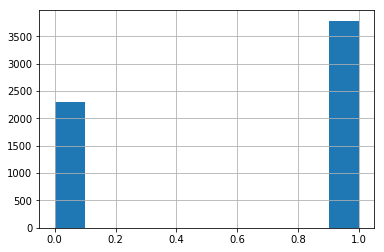

In [54]:
# le joueur 1 a plus de chance de gagner s'il est bien placé
df["potentiellement gagnant"]= df["POS_1"]<df["POS_2"]

# affichage
df["potentiellement gagnant"].hist()
plt.show()

On remarque que le data test contient effectivement des joueurs 1 plus forts que les joueurs 2 selon le classement uniquement. 

Nous n'avons pas traité les données "RESULT_G" alors qu'elles contiennent une information intéressante : il y a-t-il eu 3 sets pour un match ? Si oui on peut comprendre que les joueurs ont été en compétition et que le match a été serré. 

Pour cela, il suffit de traiter la donnée RESULT_G en splitant par espace et compter le nombre d'espace et relancer l'apprentissage. 

Enfin, nous n'avons pas utiliser l'analyse en composantes principales qui, parfois, peut apporter plus d'informations sur les variables en trouvant les dimensions rapportant le plus d'information aux données. 

Etant en condition période d'examen et puisque le but de ce test technique est plus de montrer ce que l'on sait faire plutôt que d'avoir la meilleure prédiction, je décide d'arrêter l'analyse ici afin de me concentrer sur mes examens de la semaine. 

Je vous remercie pour votre lecture, serai très attentive à vos remarques et espère avoir votre retour bientôt. 

**Mathilde**